<a href="https://colab.research.google.com/github/Dhanush-adk/intro_to_dl/blob/main/Assignment_3/Assignment_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from tqdm.notebook import tqdm
import seaborn as sns
import torch.nn.functional as F

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
np.random.seed(123)


In [113]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [114]:
# Defining the RNN model
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        #This line takes the input tensor x, which contains indices of characters, and passes it through an embedding layer (self.embedding).
        #The embedding layer converts these indices into dense vectors of fixed size.
        #These vectors are learned during training and can capture semantic similarities between characters.
        #The result is a higher-dimensional representation of the input sequence, where each character index is replaced by its corresponding embedding vector.
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        #The RNN layer returns two outputs:
        #1- the output tensor containing the output of the RNN at each time step for each sequence in the batch,
        #2-the hidden state (_) of the last time step (which is not used in this line, hence the underscore).
        output, _ = self.rnn(embedded)
        #The RNN's output contains the outputs for every time step,
        #but for this task, we're only interested in the output of the last time step because we're predicting the next character after the sequence.
        #output[:, -1, :] selects the last time step's output for every sequence in the batch (-1 indexes the last item in Python).
        output = self.fc(output[:, -1, :])  # Get the output of the last RNN cell
        return output


# Defining the RNN model
class CharLstm(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharLstm, self).__init__()
        self.hidden_size = hidden_size
        #This line takes the input tensor x, which contains indices of characters, and passes it through an embedding layer (self.embedding).
        #The embedding layer converts these indices into dense vectors of fixed size.
        #These vectors are learned during training and can capture semantic similarities between characters.
        #The result is a higher-dimensional representation of the input sequence, where each character index is replaced by its corresponding embedding vector.
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.LSTM = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        #The RNN layer returns two outputs:
        #1- the output tensor containing the output of the RNN at each time step for each sequence in the batch,
        #2-the hidden state (_) of the last time step (which is not used in this line, hence the underscore).
        output, _ = self.LSTM(embedded)
        #The RNN's output contains the outputs for every time step,
        #but for this task, we're only interested in the output of the last time step because we're predicting the next character after the sequence.
        #output[:, -1, :] selects the last time step's output for every sequence in the batch (-1 indexes the last item in Python).
        output = self.fc(output[:, -1, :])  # Get the output of the last RNN cell
        return output

class CharGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharGRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        #The RNN layer returns two outputs:
        #1- the output tensor containing the output of the RNN at each time step for each sequence in the batch,
        #2-the hidden state (_) of the last time step (which is not used in this line, hence the underscore).
        output, _ = self.gru(embedded)
        #The RNN's output contains the outputs for every time step,
        #but for this task, we're only interested in the output of the last time step because we're predicting the next character after the sequence.
        #output[:, -1, :] selects the last time step's output for every sequence in the batch (-1 indexes the last item in Python).
        output = self.fc(output[:, -1, :])  # Get the output of the last RNN cell
        return output


In [115]:
# Sample text
text = '''Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text.

At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model.

One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks.

Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each character's appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time.

Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants.

In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology'''

# Creating character vocabulary
# part of the data preprocessing step for a character-level text modeling task.
# Create mappings between characters in the text and numerical indices

#set(text): Creates a set of unique characters found in the text. The set function removes any duplicate characters.
#list(set(text)): Converts the set back into a list so that it can be sorted.
# sorted(list(set(text))): Sorts the list of unique characters.
chars = sorted(list(set(text)))
#This line creates a dictionary that maps each character to a unique index (integer)."
ix_to_char = {i: ch for i, ch in enumerate(chars)}
#Similar to the previous line, but in reverse. This line creates a dictionary that maps each unique index (integer) back to its corresponding character.
char_to_ix = {ch: i for i, ch in enumerate(chars)}
chars = sorted(list(set(text)))


# Preparing the dataset
max_length = 10  # Maximum length of input sequences
X = []
y = []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X = np.array(X)
y = np.array(y)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)


# Hyperparameters
hidden_size = 128
learning_rate = 0.005
epochs = 100

# Model, loss, and optimizer
model = CharRNN(len(chars), hidden_size, len(chars))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_list, val_loss_list, val_accuracy_list = [], [], []

# Training the model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()
    train_loss_list.append(loss.item())
    val_loss_list.append(val_loss.item())
    val_accuracy_list.append(val_accuracy.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Predicting the next character
test_str = "This is a simple example to demonstrate how to predict the next char"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")

Epoch 10, Loss: 2.2298717498779297, Validation Loss: 2.341111660003662, Validation Accuracy: 0.38655462861061096
Epoch 20, Loss: 1.7459559440612793, Validation Loss: 2.0998377799987793, Validation Accuracy: 0.4474790096282959
Epoch 30, Loss: 1.3832682371139526, Validation Loss: 2.0194802284240723, Validation Accuracy: 0.45588237047195435
Epoch 40, Loss: 1.0664764642715454, Validation Loss: 2.0297694206237793, Validation Accuracy: 0.4663865864276886
Epoch 50, Loss: 0.7769911885261536, Validation Loss: 2.0730202198028564, Validation Accuracy: 0.47689077258110046
Epoch 60, Loss: 0.5412962436676025, Validation Loss: 2.169475793838501, Validation Accuracy: 0.4831933081150055
Epoch 70, Loss: 0.3384016752243042, Validation Loss: 2.2846977710723877, Validation Accuracy: 0.47899162769317627
Epoch 80, Loss: 0.19967882335186005, Validation Loss: 2.409029483795166, Validation Accuracy: 0.4873949885368347
Epoch 90, Loss: 0.12251777946949005, Validation Loss: 2.5483977794647217, Validation Accuracy:

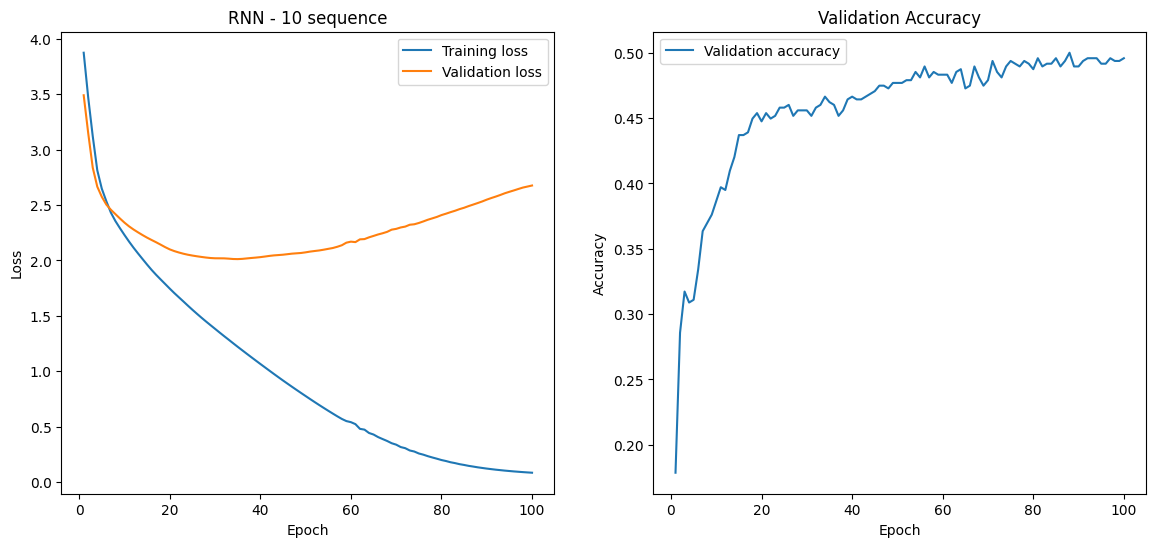

In [116]:
plt.figure(figsize=(14, 6))
epochs_list = [i for i in range(1, 100+1, 1)]

# Creating subplots
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_loss_list, label='Training loss')
plt.plot(epochs_list, val_loss_list, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN - 10 sequence')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, val_accuracy_list, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')


# Show the combined plot
plt.show()


#RNN 20

In [117]:
# Preparing the dataset
max_length = 20  # Maximum length of input sequences
X = []
y = []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X = np.array(X)
y = np.array(y)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)


# Hyperparameters
hidden_size = 128
learning_rate = 0.005
epochs = 100

# Model, loss, and optimizer
model = CharRNN(len(chars), hidden_size, len(chars))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_list, val_loss_list, val_accuracy_list = [], [], []

# Training the model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()
    train_loss_list.append(loss.item())
    val_loss_list.append(val_loss.item())
    val_accuracy_list.append(val_accuracy.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Predicting the next character
test_str = "This is a simple example to demonstrate how to predict the next char"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")

Epoch 10, Loss: 2.2470602989196777, Validation Loss: 2.4111850261688232, Validation Accuracy: 0.33966243267059326
Epoch 20, Loss: 1.7731679677963257, Validation Loss: 2.1251752376556396, Validation Accuracy: 0.43670883774757385
Epoch 30, Loss: 1.4083507061004639, Validation Loss: 1.999151587486267, Validation Accuracy: 0.4662446975708008
Epoch 40, Loss: 1.0925490856170654, Validation Loss: 1.9579277038574219, Validation Accuracy: 0.4831223487854004
Epoch 50, Loss: 0.8035778999328613, Validation Loss: 1.9824882745742798, Validation Accuracy: 0.51054847240448
Epoch 60, Loss: 0.5672680735588074, Validation Loss: 2.0568368434906006, Validation Accuracy: 0.5210970044136047
Epoch 70, Loss: 0.37254422903060913, Validation Loss: 2.177769899368286, Validation Accuracy: 0.5274261236190796
Epoch 80, Loss: 0.23261724412441254, Validation Loss: 2.3269803524017334, Validation Accuracy: 0.5168775916099548
Epoch 90, Loss: 0.14126142859458923, Validation Loss: 2.457127094268799, Validation Accuracy: 0.

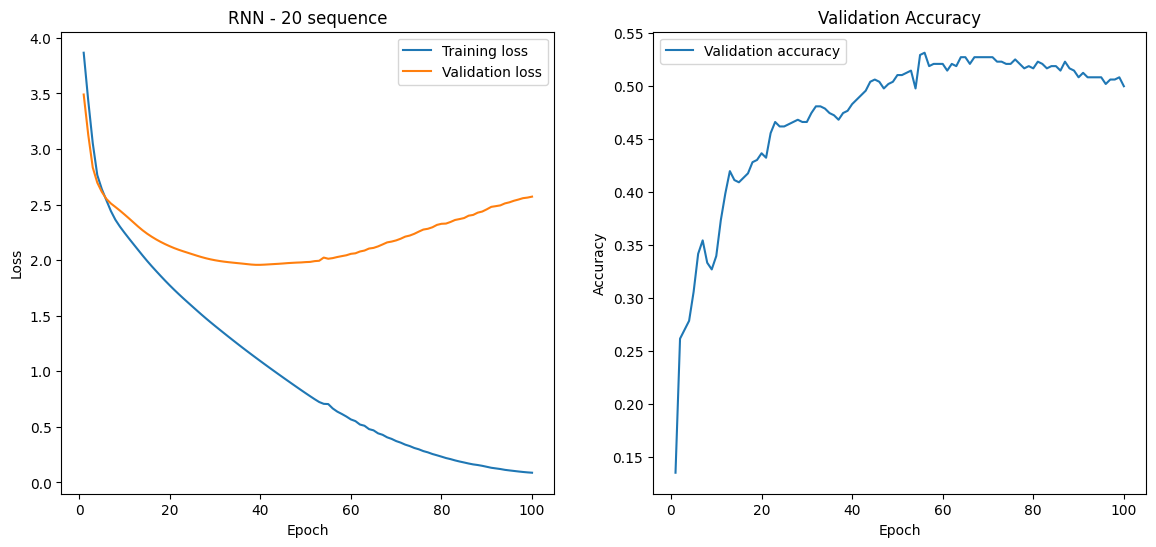

In [118]:
plt.figure(figsize=(14, 6))
epochs_list = [i for i in range(1, 100+1, 1)]

# Creating subplots
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_loss_list, label='Training loss')
plt.plot(epochs_list, val_loss_list, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN - 20 sequence')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, val_accuracy_list, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')


# Show the combined plot
plt.show()


#RNN 30

In [119]:
# Preparing the dataset
max_length = 30  # Maximum length of input sequences
X = []
y = []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X = np.array(X)
y = np.array(y)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)


# Hyperparameters
hidden_size = 128
learning_rate = 0.005
epochs = 100

# Model, loss, and optimizer
model = CharRNN(len(chars), hidden_size, len(chars))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_list, val_loss_list, val_accuracy_list = [], [], []

# Training the model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()
    train_loss_list.append(loss.item())
    val_loss_list.append(val_loss.item())
    val_accuracy_list.append(val_accuracy.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Predicting the next character
test_str = "This is a simple example to demonstrate how to predict the next char"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")

Epoch 10, Loss: 2.2212560176849365, Validation Loss: 2.480990171432495, Validation Accuracy: 0.31779661774635315
Epoch 20, Loss: 1.7404588460922241, Validation Loss: 2.242800712585449, Validation Accuracy: 0.40042373538017273
Epoch 30, Loss: 1.386049747467041, Validation Loss: 2.0989673137664795, Validation Accuracy: 0.43220338225364685
Epoch 40, Loss: 1.0811352729797363, Validation Loss: 2.035191774368286, Validation Accuracy: 0.4682203531265259
Epoch 50, Loss: 0.8194354176521301, Validation Loss: 2.0486443042755127, Validation Accuracy: 0.47457626461982727
Epoch 60, Loss: 0.5790985822677612, Validation Loss: 2.1100542545318604, Validation Accuracy: 0.49152541160583496
Epoch 70, Loss: 0.38462501764297485, Validation Loss: 2.218566417694092, Validation Accuracy: 0.4894067943096161
Epoch 80, Loss: 0.2394070029258728, Validation Loss: 2.334826946258545, Validation Accuracy: 0.4957627058029175
Epoch 90, Loss: 0.14807626605033875, Validation Loss: 2.491071939468384, Validation Accuracy: 0.

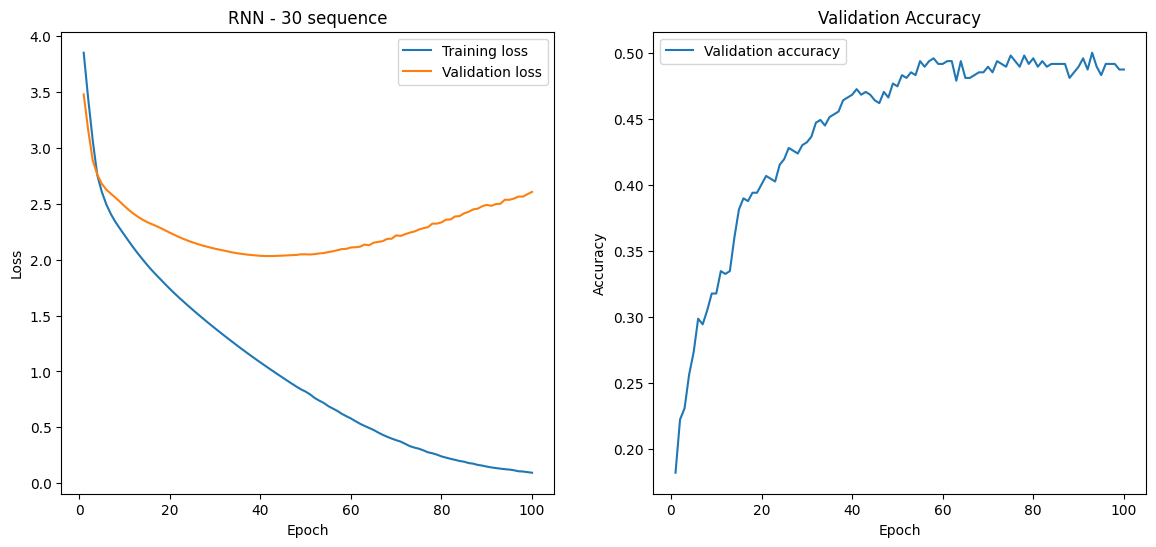

In [120]:
plt.figure(figsize=(14, 6))
epochs_list = [i for i in range(1, 100+1, 1)]

# Creating subplots
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_loss_list, label='Training loss')
plt.plot(epochs_list, val_loss_list, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN - 30 sequence')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, val_accuracy_list, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')


# Show the combined plot
plt.show()


#LSTM 10

In [121]:
# Preparing the dataset
max_length = 10  # Maximum length of input sequences
X = []
y = []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X = np.array(X)
y = np.array(y)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)


# Hyperparameters
hidden_size = 128
learning_rate = 0.005
epochs = 100

# Model, loss, and optimizer
model = CharLstm(len(chars), hidden_size, len(chars))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_list, val_loss_list, val_accuracy_list = [], [], []

# Training the model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()
    train_loss_list.append(loss.item())
    val_loss_list.append(val_loss.item())
    val_accuracy_list.append(val_accuracy.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')


total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Predicting the next character
test_str = "This Course is an introduction to deep learnin"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")

Epoch 10, Loss: 2.5445287227630615, Validation Loss: 2.516864776611328, Validation Accuracy: 0.3256302773952484
Epoch 20, Loss: 2.0198922157287598, Validation Loss: 2.2092621326446533, Validation Accuracy: 0.3949579894542694
Epoch 30, Loss: 1.6272224187850952, Validation Loss: 2.058624267578125, Validation Accuracy: 0.4495798647403717
Epoch 40, Loss: 1.282071828842163, Validation Loss: 1.988515853881836, Validation Accuracy: 0.46008405089378357
Epoch 50, Loss: 0.9668115377426147, Validation Loss: 1.9848966598510742, Validation Accuracy: 0.47268909215927124
Epoch 60, Loss: 0.6868643164634705, Validation Loss: 2.034899950027466, Validation Accuracy: 0.47478994727134705
Epoch 70, Loss: 0.4473596513271332, Validation Loss: 2.112797260284424, Validation Accuracy: 0.4831933081150055
Epoch 80, Loss: 0.2729787826538086, Validation Loss: 2.2304422855377197, Validation Accuracy: 0.46008405089378357
Epoch 90, Loss: 0.16433468461036682, Validation Loss: 2.347900152206421, Validation Accuracy: 0.47

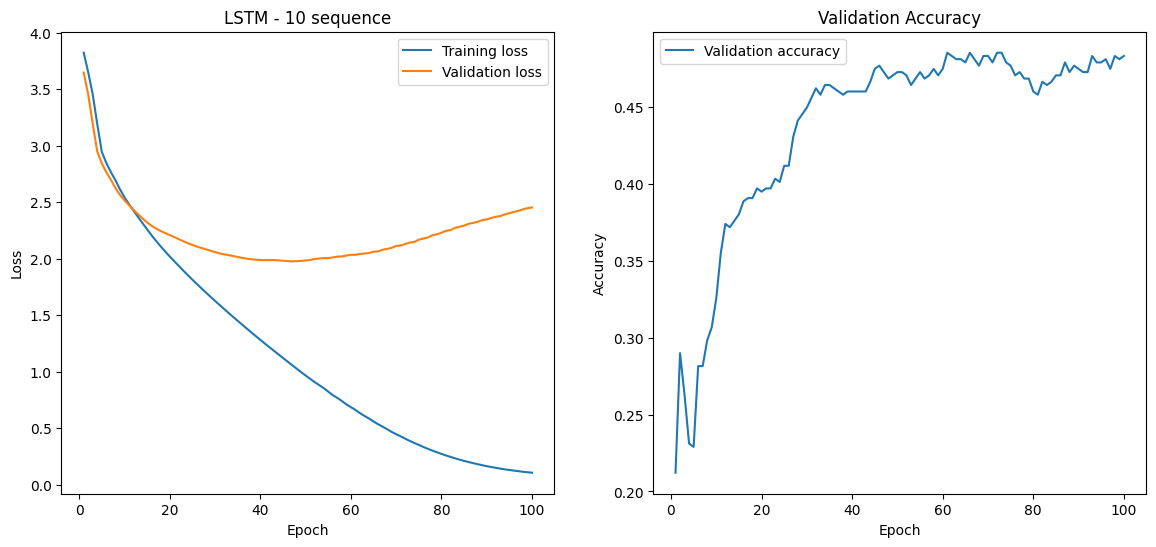

In [122]:
plt.figure(figsize=(14, 6))
epochs_list = [i for i in range(1, 100+1, 1)]

# Creating subplots
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_loss_list, label='Training loss')
plt.plot(epochs_list, val_loss_list, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM - 10 sequence')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, val_accuracy_list, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')


# Show the combined plot
plt.show()


#LSTM 20

In [124]:
# Preparing the dataset
max_length = 20  # Maximum length of input sequences
X = []
y = []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X = np.array(X)
y = np.array(y)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)


# Hyperparameters
hidden_size = 128
learning_rate = 0.005
epochs = 100

# Model, loss, and optimizer
model = CharLstm(len(chars), hidden_size, len(chars))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_list, val_loss_list, val_accuracy_list = [], [], []

# Training the model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()
    train_loss_list.append(loss.item())
    val_loss_list.append(val_loss.item())
    val_accuracy_list.append(val_accuracy.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')


total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Predicting the next character
test_str = "This Course is an introduction to deep learnin"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")

Epoch 10, Loss: 2.5607750415802, Validation Loss: 2.577341318130493, Validation Accuracy: 0.31434598565101624
Epoch 20, Loss: 2.0478951930999756, Validation Loss: 2.240154504776001, Validation Accuracy: 0.38396623730659485
Epoch 30, Loss: 1.6512917280197144, Validation Loss: 2.0645225048065186, Validation Accuracy: 0.4514767825603485
Epoch 40, Loss: 1.3008214235305786, Validation Loss: 2.0017764568328857, Validation Accuracy: 0.48101264238357544
Epoch 50, Loss: 0.9778704047203064, Validation Loss: 1.9737080335617065, Validation Accuracy: 0.4831223487854004
Epoch 60, Loss: 0.6961485743522644, Validation Loss: 2.004990816116333, Validation Accuracy: 0.4831223487854004
Epoch 70, Loss: 0.46063271164894104, Validation Loss: 2.0676114559173584, Validation Accuracy: 0.4915611445903778
Epoch 80, Loss: 0.2888762056827545, Validation Loss: 2.147172212600708, Validation Accuracy: 0.502109706401825
Epoch 90, Loss: 0.1723622828722, Validation Loss: 2.276658296585083, Validation Accuracy: 0.48312234

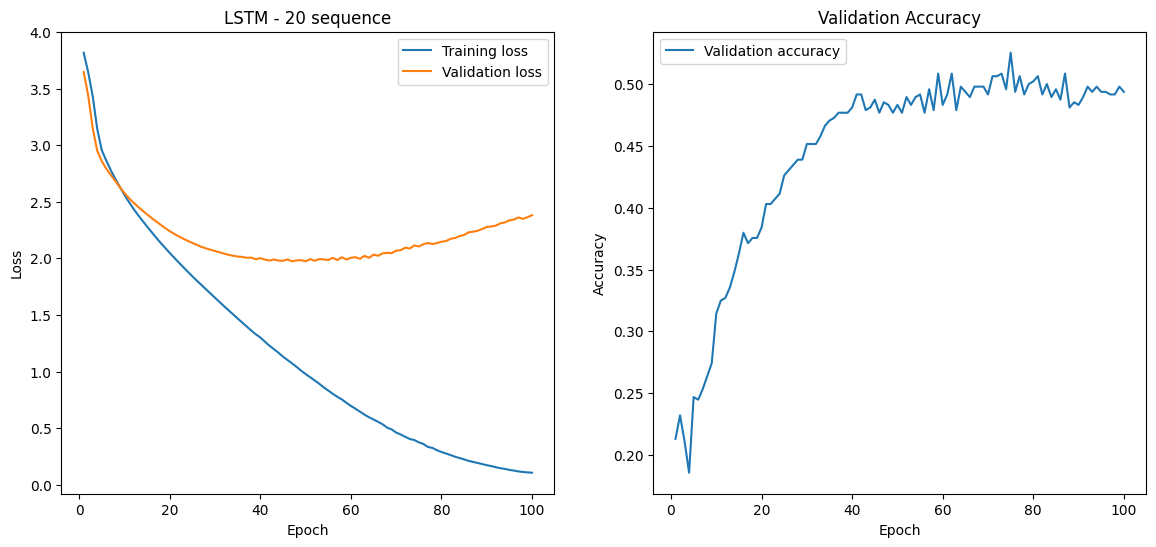

In [125]:
plt.figure(figsize=(14, 6))
epochs_list = [i for i in range(1, 100+1, 1)]

# Creating subplots
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_loss_list, label='Training loss')
plt.plot(epochs_list, val_loss_list, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM - 20 sequence')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, val_accuracy_list, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')


# Show the combined plot
plt.show()


#LSTM 30

In [126]:
# Preparing the dataset
max_length = 30  # Maximum length of input sequences
X = []
y = []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X = np.array(X)
y = np.array(y)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)


# Hyperparameters
hidden_size = 128
learning_rate = 0.005
epochs = 100

# Model, loss, and optimizer
model = CharLstm(len(chars), hidden_size, len(chars))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_list, val_loss_list, val_accuracy_list = [], [], []

# Training the model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()
    train_loss_list.append(loss.item())
    val_loss_list.append(val_loss.item())
    val_accuracy_list.append(val_accuracy.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')


total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Predicting the next character
test_str = "This Course is an introduction to deep learnin"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")

Epoch 10, Loss: 2.519169330596924, Validation Loss: 2.632059097290039, Validation Accuracy: 0.26906779408454895
Epoch 20, Loss: 2.020186424255371, Validation Loss: 2.314181089401245, Validation Accuracy: 0.37711864709854126
Epoch 30, Loss: 1.6300398111343384, Validation Loss: 2.1783883571624756, Validation Accuracy: 0.4173728823661804
Epoch 40, Loss: 1.2870395183563232, Validation Loss: 2.1123759746551514, Validation Accuracy: 0.4406779706478119
Epoch 50, Loss: 0.9774072766304016, Validation Loss: 2.1076483726501465, Validation Accuracy: 0.44915252923965454
Epoch 60, Loss: 0.6989741921424866, Validation Loss: 2.140178918838501, Validation Accuracy: 0.47033897042274475
Epoch 70, Loss: 0.48958098888397217, Validation Loss: 2.2443859577178955, Validation Accuracy: 0.46398305892944336
Epoch 80, Loss: 0.31512215733528137, Validation Loss: 2.342679500579834, Validation Accuracy: 0.45974576473236084
Epoch 90, Loss: 0.20098991692066193, Validation Loss: 2.472383499145508, Validation Accuracy: 

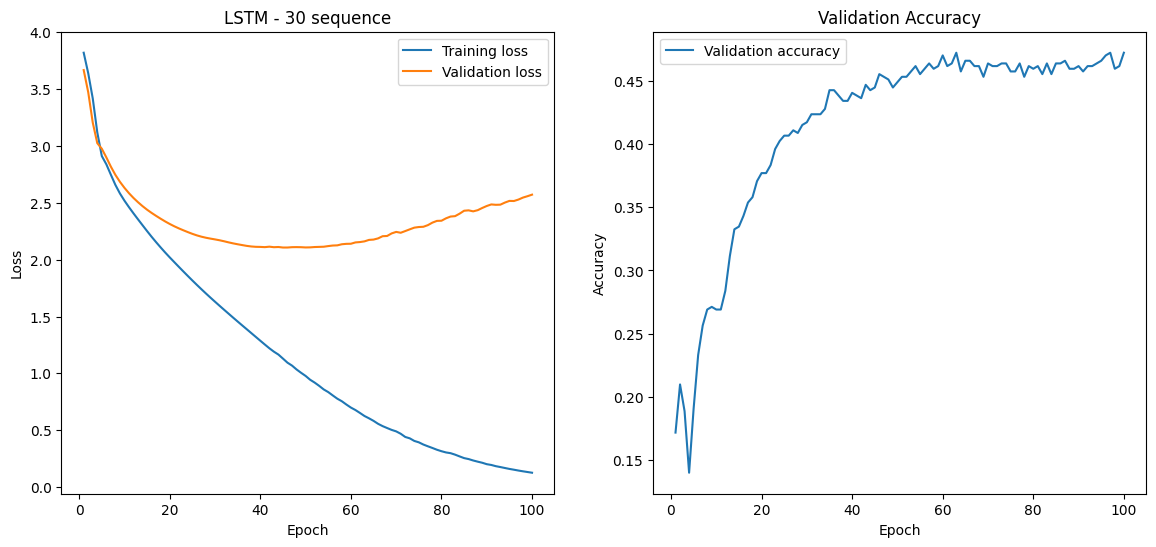

In [127]:
plt.figure(figsize=(14, 6))
epochs_list = [i for i in range(1, 100+1, 1)]

# Creating subplots
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_loss_list, label='Training loss')
plt.plot(epochs_list, val_loss_list, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM - 30 sequence')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, val_accuracy_list, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')


# Show the combined plot
plt.show()


#GRU 10

In [128]:
# Preparing the dataset
max_length = 10  # Maximum length of input sequences
X = []
y = []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X = np.array(X)
y = np.array(y)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)


# Hyperparameters
hidden_size = 128
learning_rate = 0.005
epochs = 100

# Model, loss, and optimizer
model = CharGRU(len(chars), hidden_size, len(chars))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_list, val_loss_list, val_accuracy_list = [], [], []

# Training the model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()
    train_loss_list.append(loss.item())
    val_loss_list.append(val_loss.item())
    val_accuracy_list.append(val_accuracy.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')


total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Predicting the next character
test_str = "This Course is an introduction to deep learnin"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")

Epoch 10, Loss: 2.384629487991333, Validation Loss: 2.3909337520599365, Validation Accuracy: 0.3592437207698822
Epoch 20, Loss: 1.872780203819275, Validation Loss: 2.143808126449585, Validation Accuracy: 0.40756306052207947
Epoch 30, Loss: 1.4569307565689087, Validation Loss: 1.9934645891189575, Validation Accuracy: 0.4474790096282959
Epoch 40, Loss: 1.0822601318359375, Validation Loss: 1.962240219116211, Validation Accuracy: 0.4663865864276886
Epoch 50, Loss: 0.7410738468170166, Validation Loss: 1.987990140914917, Validation Accuracy: 0.5042017102241516
Epoch 60, Loss: 0.45645299553871155, Validation Loss: 2.075099468231201, Validation Accuracy: 0.5021008849143982
Epoch 70, Loss: 0.25565797090530396, Validation Loss: 2.1928153038024902, Validation Accuracy: 0.5084033608436584
Epoch 80, Loss: 0.1407655030488968, Validation Loss: 2.3530707359313965, Validation Accuracy: 0.49579834938049316
Epoch 90, Loss: 0.08728276938199997, Validation Loss: 2.475113868713379, Validation Accuracy: 0.48

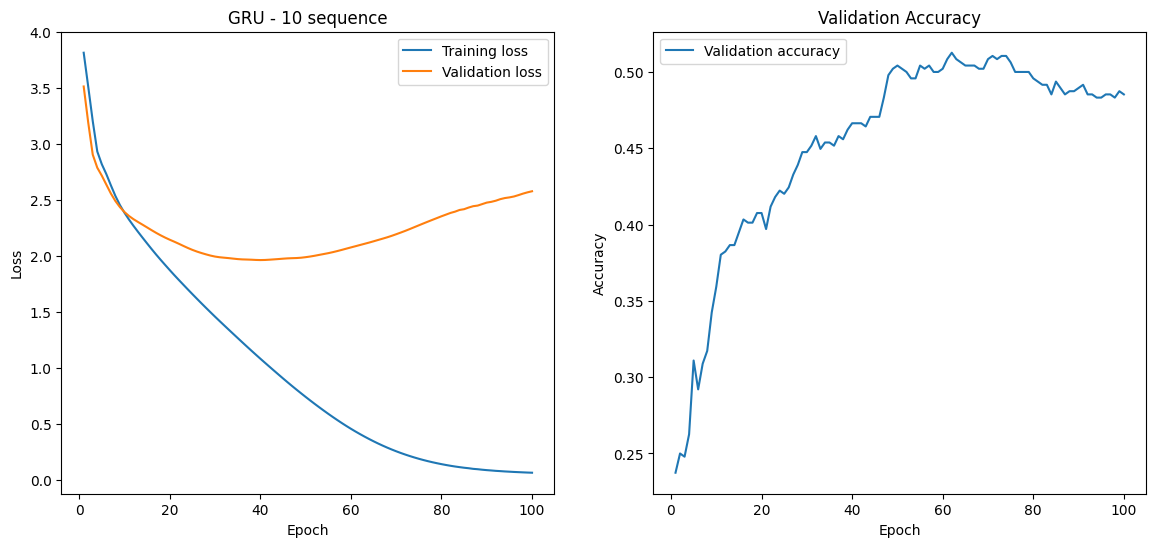

In [129]:
plt.figure(figsize=(14, 6))
epochs_list = [i for i in range(1, 100+1, 1)]

# Creating subplots
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_loss_list, label='Training loss')
plt.plot(epochs_list, val_loss_list, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU - 10 sequence')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, val_accuracy_list, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')


# Show the combined plot
plt.show()


#GRU 20

In [130]:
# Preparing the dataset
max_length = 20  # Maximum length of input sequences
X = []
y = []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X = np.array(X)
y = np.array(y)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)


# Hyperparameters
hidden_size = 128
learning_rate = 0.005
epochs = 100

# Model, loss, and optimizer
model = CharGRU(len(chars), hidden_size, len(chars))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_list, val_loss_list, val_accuracy_list = [], [], []

# Training the model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()
    train_loss_list.append(loss.item())
    val_loss_list.append(val_loss.item())
    val_accuracy_list.append(val_accuracy.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')


total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Predicting the next character
test_str = "This Course is an introduction to deep learnin"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")

Epoch 10, Loss: 2.381399154663086, Validation Loss: 2.4686036109924316, Validation Accuracy: 0.3122362792491913
Epoch 20, Loss: 1.8580021858215332, Validation Loss: 2.119898557662964, Validation Accuracy: 0.4345991313457489
Epoch 30, Loss: 1.4504975080490112, Validation Loss: 1.9805989265441895, Validation Accuracy: 0.4746835231781006
Epoch 40, Loss: 1.0884697437286377, Validation Loss: 1.9141417741775513, Validation Accuracy: 0.51054847240448
Epoch 50, Loss: 0.7642514109611511, Validation Loss: 1.9134933948516846, Validation Accuracy: 0.5464134812355042
Epoch 60, Loss: 0.49705466628074646, Validation Loss: 1.975813388824463, Validation Accuracy: 0.5569620132446289
Epoch 70, Loss: 0.2997981607913971, Validation Loss: 2.086459159851074, Validation Accuracy: 0.5400843620300293
Epoch 80, Loss: 0.17189309000968933, Validation Loss: 2.2081897258758545, Validation Accuracy: 0.5274261236190796
Epoch 90, Loss: 0.10095237195491791, Validation Loss: 2.3535194396972656, Validation Accuracy: 0.523

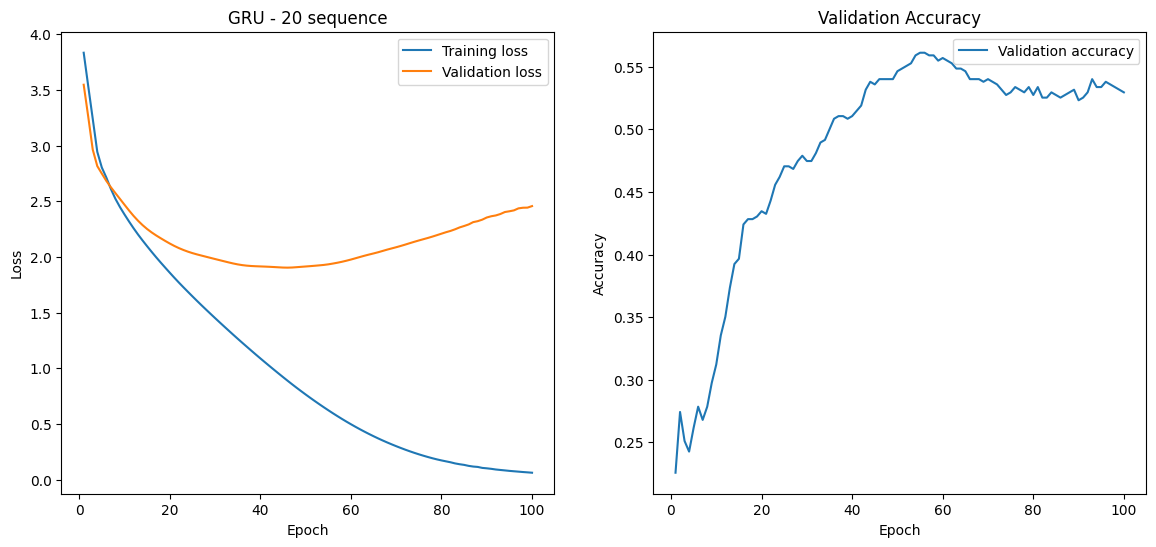

In [131]:
plt.figure(figsize=(14, 6))
epochs_list = [i for i in range(1, 100+1, 1)]

# Creating subplots
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_loss_list, label='Training loss')
plt.plot(epochs_list, val_loss_list, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU - 20 sequence')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, val_accuracy_list, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')


# Show the combined plot
plt.show()


#GRU 30

In [133]:
# Preparing the dataset
max_length = 30  # Maximum length of input sequences
X = []
y = []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X = np.array(X)
y = np.array(y)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)


# Hyperparameters
hidden_size = 128
learning_rate = 0.005
epochs = 100

# Model, loss, and optimizer
model = CharGRU(len(chars), hidden_size, len(chars))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_list, val_loss_list, val_accuracy_list = [], [], []

# Training the model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()
    train_loss_list.append(loss.item())
    val_loss_list.append(val_loss.item())
    val_accuracy_list.append(val_accuracy.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')


total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Predicting the next character
test_str = "This Course is an introduction to deep learnin"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")

Epoch 10, Loss: 2.391552686691284, Validation Loss: 2.5534005165100098, Validation Accuracy: 0.3050847351551056
Epoch 20, Loss: 1.8696229457855225, Validation Loss: 2.239694833755493, Validation Accuracy: 0.402542382478714
Epoch 30, Loss: 1.463815689086914, Validation Loss: 2.1006171703338623, Validation Accuracy: 0.4237288236618042
Epoch 40, Loss: 1.0997724533081055, Validation Loss: 2.0314974784851074, Validation Accuracy: 0.4618644118309021
Epoch 50, Loss: 0.7781121730804443, Validation Loss: 2.01664400100708, Validation Accuracy: 0.48728814721107483
Epoch 60, Loss: 0.507293701171875, Validation Loss: 2.0807156562805176, Validation Accuracy: 0.48728814721107483
Epoch 70, Loss: 0.30617591738700867, Validation Loss: 2.226855754852295, Validation Accuracy: 0.4957627058029175
Epoch 80, Loss: 0.17776882648468018, Validation Loss: 2.38572359085083, Validation Accuracy: 0.4894067943096161
Epoch 90, Loss: 0.10385552048683167, Validation Loss: 2.5315046310424805, Validation Accuracy: 0.48940

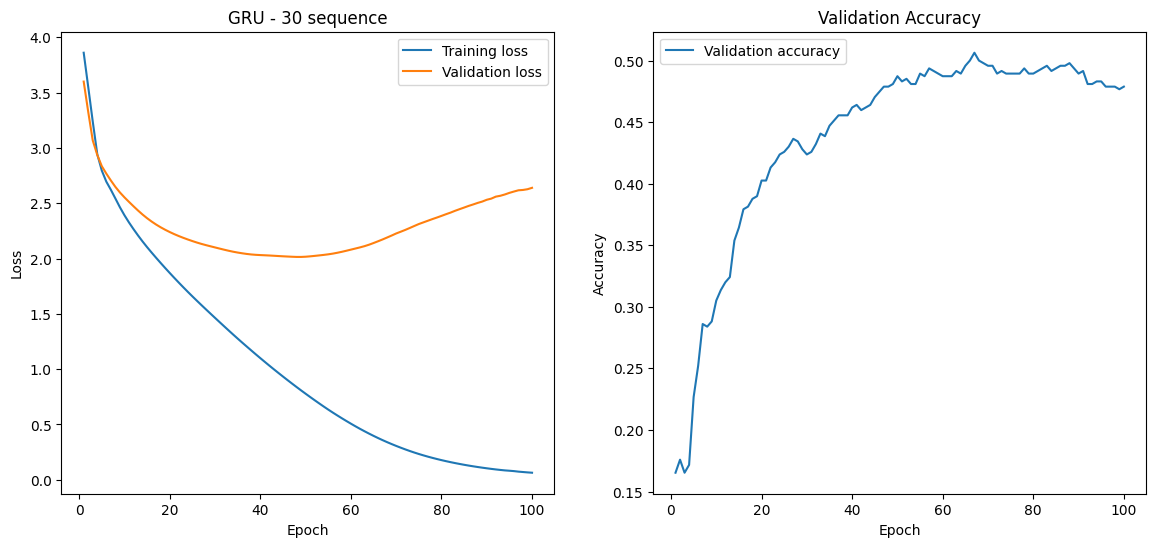

In [134]:
plt.figure(figsize=(14, 6))
epochs_list = [i for i in range(1, 100+1, 1)]

# Creating subplots
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_loss_list, label='Training loss')
plt.plot(epochs_list, val_loss_list, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU - 30 sequence')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, val_accuracy_list, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')


# Show the combined plot
plt.show()
